#### Vicky van der Wagt

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import regex as re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here

from string import punctuation
import matplotlib.pyplot as plt


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/vicky/Documents/GitHub/ADS509-Assignment2.2/M1 Results/"
lyrics_path = "/Users/vicky/Documents/GitHub/ADS509-Assignment2.2/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [5]:
# Read in the lyrics data

lyrics_path = os.path.join(data_location, lyrics_folder)

# initialize lists
artist_list = []
song_list = []
lyrics_list = []

# for every artist folder in the path...
for artist in os.listdir(lyrics_path):
    # find the artist path
    artist_path = os.path.join(lyrics_path, artist)
    if os.path.isdir(artist_path):
        # for each song in the artist path...
        for song_file in os.listdir(artist_path):
            # if .txt file...
            if song_file.endswith('.txt'):
                # generate song path
                song_path = os.path.join(artist_path, song_file)
                # read lyrics
                with open(song_path, 'r', encoding='utf-8') as file:
                    song_lyrics = file.read().strip() 
                    # exclude lyrics until after 4th newline character (consistent formatting in files)
                    newline_count = 0
                    start_index = 0
                    for i, char in enumerate(song_lyrics):
                        if char == '\n':
                            newline_count += 1
                            if newline_count == 4:
                                start_index = i + 1
                                break
                    # extract song title from the lyrics (between the quotes)
                    song_title = None
                    quote_start = song_lyrics.find('"')
                    if quote_start != -1:
                        quote_end = song_lyrics.find('"', quote_start + 1)
                        if quote_end != -1:
                            song_title = song_lyrics[quote_start + 1:quote_end].strip()
                    # append data to the lists
                    artist_list.append(artist)
                    song_list.append(song_title)
                    # don't include lyrics until after the 4th newline character in the file
                    lyrics_list.append(song_lyrics[start_index:].strip()) 

# generate dataframe
lyrics_df = pd.DataFrame({
    'artist': artist_list,
    'song': song_list,
    'lyrics': lyrics_list
})

lyrics_df.head()

,artist,song,lyrics
0,robyn,Include Me Out,"It is really very simple\nJust a single pulse,..."
1,robyn,Electric,Electric...\n\nIt's electric\nIt's a natural h...
2,robyn,Beach 2K20,(So you wanna go out?\nHow you gonna get there...
3,robyn,Love Kills,If you're looking for love\nGet a heart made o...
4,robyn,Time Machine,"Hey, what did I do?\nCan't believe the fit I j..."


In [6]:
# Read in the twitter data

# twitter data path
twitter_path = os.path.join(data_location, twitter_folder)

# intiailize lists
artist_list = []
description_list = []

for data_file in os.listdir(os.path.join(data_location, twitter_folder)):
    if "data" in data_file:
        # Extract artist name from file name
        artist_name = data_file.split("_")[0]
        with open(os.path.join(data_location, twitter_folder, data_file), 'r', encoding='utf-8') as file:
            next(file)  # Skip header line
            for line in file:
                columns = line.strip().split('\t')
                if len(columns) >= 7:
                    description_list.append(columns[6])
                    artist_list.append(artist_name)


# create the dataframe
twitter_df = pd.DataFrame({
    'artist': artist_list,
    'description': description_list
})

# replace arist name
twitter_df['artist'] = twitter_df['artist'].replace('robynkonichiwa', 'robyn')

In [7]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

def read_words(file):
    '''This function reads words from a file, after the first blank line'''
    with open(file, 'r', encoding='utf-8') as f:
        # make a list of all lines
        lines = f.readlines()
        # find location (index) of the first blank line
        first_blank_index = next(idx for idx, line in enumerate(lines) if line.strip() == '')
        # extract the words after the first blank line (blank index location +1)
        words = [line.strip() for line in lines[first_blank_index + 1:] if line.strip()]
    return words

#read in the positive and negative words
positive_words = read_words(positive_words_file)
negative_words = read_words(negative_words_file)

#combine the positive and negative words
all_words = positive_words + negative_words

#make a dataframe containing all the words
sentiment_scores = pd.DataFrame({'word':all_words})

#assign scores
sentiment_scores.loc[sentiment_scores['word'].isin(positive_words), 'score'] = 1
sentiment_scores.loc[sentiment_scores['word'].isin(negative_words), 'score'] = -1

#convert score to integer
sentiment_scores['score'] = sentiment_scores['score'].astype(int)


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


### Preprocessing

Not removing stopwords since we will just check for the positive/negative words. Will just tokenize & remove punctuation to generate word tokens.

In [8]:
tw_punct = punctuation
 
def remove_punctuation(text, punct_set=tw_punct) : 
    
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    text = text.split()
    return(text)
    
def prepare(text, pipeline) : 
    tokens = str(text)

    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

preprocessing_pipeline = [str.lower, remove_punctuation, tokenize]

lyrics_df["tokens"] = lyrics_df["lyrics"].apply(prepare,pipeline=preprocessing_pipeline)
twitter_df["tokens"] = twitter_df["description"].apply(prepare,pipeline=preprocessing_pipeline)


In [9]:
def calculate_sentiment(tokens):
    '''This function returns the sentiment score for each record'''
    score = 0
    for token in tokens:
        if token in sentiment_scores['word'].values:
            score += sentiment_scores.loc[sentiment_scores['word'] == token, 'score'].values[0]
    return score

lyrics_df['sentiment_score'] = lyrics_df['tokens'].apply(calculate_sentiment)

lyrics_df.head()

,artist,song,lyrics,tokens,sentiment_score
0,robyn,Include Me Out,"It is really very simple\nJust a single pulse,...","[it, is, really, very, simple, just, a, single...",-3
1,robyn,Electric,Electric...\n\nIt's electric\nIt's a natural h...,"[electric, its, electric, its, a, natural, hig...",-6
2,robyn,Beach 2K20,(So you wanna go out?\nHow you gonna get there...,"[so, you, wanna, go, out, how, you, gonna, get...",20
3,robyn,Love Kills,If you're looking for love\nGet a heart made o...,"[if, youre, looking, for, love, get, a, heart,...",-23
4,robyn,Time Machine,"Hey, what did I do?\nCan't believe the fit I j...","[hey, what, did, i, do, cant, believe, the, fi...",-5


### Questions


**Q: Overall, which artist has the higher average sentiment per song?**

A: Overall, Cher has the highest average sentiment score (3.42), compared to Robyn (2.56).

In [10]:
# your code here
average_sentiment = lyrics_df.groupby('artist')['sentiment_score'].mean().reset_index()
average_sentiment

,artist,sentiment_score
0,cher,3.424051
1,robyn,2.567308


**Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?**

A: For Cher, the 3 songs with the highest sentiment scores are:
1. Perfection
2. My Love
3. Love and Understanding

I believe the factors driving the high sentiment scores are the repeated mentions of positive words like 'Love' and 'Perfection'.  

The 3 Cher songs with the lowest sentiment scores are:
1. I walk on Guilded Splinters
2. Outrageous
3. When you walk away

I think the presence of many words with negative connotations such as 'Outrageous', 'misfortune', 'poison', 'lazy', 'enemies', etc. are driving the low sentiment score. There are many instances in which these words are repeated many times, and each instance causes the sentiment score to drop.

In [11]:
cher_songs = lyrics_df[lyrics_df['artist'] == 'cher']
highest_sentiments = cher_songs.sort_values(by='sentiment_score', ascending=False).head(3)
lowest_sentiments = cher_songs.sort_values(by='sentiment_score').head(3)

for index, song in highest_sentiments.iterrows():
    print(f"Song: {song['song']}")
    '''Commented out lyrics after analysis to shorten output'''
   # print(f"Lyrics:\n{song['lyrics']}\n")

Song: Perfection
Song: My Love
Song: Love And Understanding


In [12]:
for index, song in lowest_sentiments.iterrows():
    print(f"Song: {song['song']}")
    '''Commented out lyrics after analysis to shorten output'''
    #print(f"Lyrics:\n{song['lyrics']}\n")

Song: I Walk On Guilded Splinters
Song: Outrageous
Song: When You Walk Away


**Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?**

A: For Robyn, the 3 songs with the highest sentiments are:
1. Love is Free
2. Indestructible
3. U Should Know Better.

Similar to the songs with the highest sentiments by Cher, I believe the frequent occurence of the word 'Love' in these songs is contributing to the high score. Additionally there are many instances of other words wtih positive sentiments such as 'free' and 'light.' The song 'U Should Know Better' doesn't seem very positive, but the frequency of the positive word 'better' is likely driving up the score.

The 3 songs with the lowest sentiments are:
1. Don't Fucking Tell Me What to Do
2. Criminal Intent
3. Love Kills

The 3 songs with the lowest sentiment contain many instances of 'kills' or 'killing', which have negative sentiment scores. Other words with negative intent such as 'criminal', 'lewd', 'penalty', and 'wreck' are also often found in these 3 songs.

In [13]:
robyn_songs = lyrics_df[lyrics_df['artist'] == 'robyn']

highest_sentiments = robyn_songs.sort_values(by='sentiment_score', ascending=False).head(3)
lowest_sentiments = robyn_songs.sort_values(by='sentiment_score')
lowest_sentiments = lowest_sentiments.drop_duplicates(subset=['song']).head(3)

for index, song in highest_sentiments.iterrows():
    print(f"Song: {song['song']}")
    '''Commented out lyrics after analysis to shorten output'''
    #print(f"Lyrics:\n{song['lyrics']}\n")


Song: Love Is Free
Song: Indestructible
Song: U Should Know Better


In [14]:
for index, song in lowest_sentiments.iterrows():
    print(f"Song: {song['song']}")
    '''Commented out lyrics after analysis to shorten output'''
    #print(f"Lyrics:\n{song['lyrics']}\n")

Song: Don't Fucking Tell Me What To Do
Song: Criminal Intent
Song: Love Kills



**Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.**


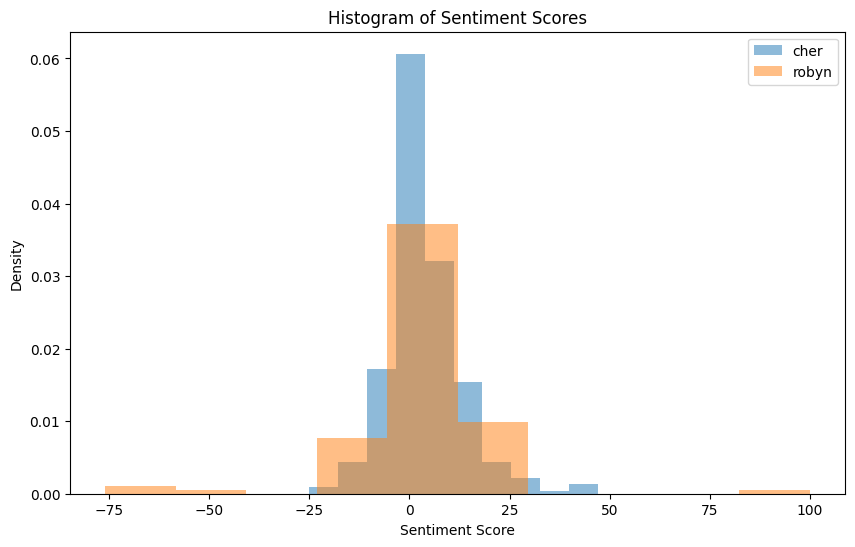

In [15]:
cher_scores = cher_songs['sentiment_score']
robyn_scores = robyn_songs['sentiment_score']
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(cher_scores, bins=10, alpha=0.5, label='cher', density=True)
plt.hist(robyn_scores, bins=10, alpha=0.5, label='robyn', density=True)

# Add labels and title
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

# Show the plot
plt.legend()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [16]:
# your code here

positive_emojis = ['💕', '❤️', '😍', '😘', '😃', '👍', '🙌', '😎', '😊', '💜','💚','💗','🧡','💛','💙', '💞','💘']
negative_emojis = ['😭', '😖', '😡', '🥲','👿','🚫','☁️','🤒','💣','🥶', '🙁','😳','🥱','☠️','🧟‍♂️', '💔', '❤️‍🩹']

def calculate_sentiment(text):
    score = 0
    # use un tokenized description so we can analyze every character (emojis are one character so this is ok)
    tokens = list(text)  
    for token in tokens:
        if token in positive_emojis:
            score += 1
        elif token in negative_emojis:
            score -= 1
    return score

twitter_df['sentiment_score'] = twitter_df['description'].apply(calculate_sentiment)

**Q: What is the average sentiment of your two artists?**

A: The average sentiment for Cher is .05, while the average sentiment for Robyn is .02. The average sentiment is positive, and Cher followers, similarly to Cher song lyrics, have a high average sentiment in their tweets.

In [17]:
average_sentiment = twitter_df.groupby('artist')['sentiment_score'].mean().reset_index()
average_sentiment

,artist,sentiment_score
0,cher,0.050778
1,robyn,0.023517


**Q: Which positive emoji is the most popular for each artist? Which negative emoji?**

A: 

**Cher Followers**

The most common positive emoji used by Cher followers is: 💙

The most common negative emoji used by Cher followers is: 🚫

**Robyn Followers**
The most common positive emoji used by Robyn followers is: 💙

The most common negative emoji used by Robyn followers is: 💔

In [18]:
cher_tweets = twitter_df[twitter_df['artist'] == 'cher']
robyn_tweets = twitter_df[twitter_df['artist']=='robyn']

positive_emoji_cher_counter = Counter()
negative_emoji_cher_counter = Counter()
positive_emoji_robyn_counter = Counter()
negative_emoji_robyn_counter = Counter()

# count
for desc in cher_tweets['description']:
    # count frequency of positive emojis in each description
    positive_emoji_cher_counter.update([char for char in desc if char in positive_emojis])

for desc in cher_tweets['description']:
    # count frequency of negative emojis in each description
    negative_emoji_cher_counter.update([char for char in desc if char in negative_emojis])

top_positive_emojis_cher = positive_emoji_cher_counter.most_common(3)
top_negative_emojis_cher = negative_emoji_cher_counter.most_common(3)

for desc in robyn_tweets['description']:
    # count frequency of positive emojis in each description
    positive_emoji_robyn_counter.update([char for char in desc if char in positive_emojis])

for desc in robyn_tweets['description']:
    # count frequency of negative emojis in each description
    negative_emoji_robyn_counter.update([char for char in desc if char in negative_emojis])

top_positive_emojis_robyn = positive_emoji_robyn_counter.most_common(3)
top_negative_emojis_robyn = negative_emoji_robyn_counter.most_common(3)

#printing results
print("Top 3 most popular positive emojis (Cher Followers):")
for emoji, count in top_positive_emojis_cher:
    print(f"{emoji}: {count} occurrences")

print("\nTop 3 most popular negative emojis (Cher Followers):")
for emoji, count in top_negative_emojis_cher:
    print(f"{emoji}: {count} occurrences")

print("\n\nTop 3 most popular positive emojis (Robyn Followers):")
for emoji, count in top_positive_emojis_robyn:
    print(f"{emoji}: {count} occurrences")

print("\nTop 3 most popular negative emojis (Robyn Followers):")
for emoji, count in top_negative_emojis_robyn:
    print(f"{emoji}: {count} occurrences")

Top 3 most popular positive emojis (Cher Followers):
💙: 21379 occurrences
💜: 16550 occurrences
💕: 11141 occurrences

Top 3 most popular negative emojis (Cher Followers):
🚫: 3240 occurrences
💔: 1611 occurrences
😭: 730 occurrences


Top 3 most popular positive emojis (Robyn Followers):
💙: 809 occurrences
💜: 739 occurrences
💛: 481 occurrences

Top 3 most popular negative emojis (Robyn Followers):
💔: 60 occurrences
🚫: 55 occurrences
😭: 41 occurrences
